In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
import pickle
import dagshub
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import mlflow
import warnings
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt

2024-10-30 13:25:19.682685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 13:25:21.229543: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-10-30 13:25:21.229629: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-10-30 13:25:21.234897: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2024-10-30 13:25:21.462321: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [2]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize dagshub repo
try:
    dagshub.init(repo_owner="hedredo", repo_name="dagshub_p7", mlflow=True)
    mlflow.set_experiment("p7")
except Exception as e:
    print("Dagshub repo can't be initialized:", e)

# Initialiser tqdm pour pandas
tqdm.pandas()

# Set a random seed
SEED = 314
np.random.seed(SEED)
print("Random seed set to", SEED)

Accessing as hedredo

Initialized MLflow to track repo "hedredo/dagshub_p7"

Repository hedredo/dagshub_p7 initialized!

Random seed set to 314


In [3]:
# Check if GPU and CUDA are available
gpu = tf.config.list_physical_devices("GPU")
cuda = torch.cuda.is_available()
print("Tensorflow framework: GPU is", "available" if gpu else "NOT AVAILABLE")
print("Pytorch framework: CUDA is", "available" if cuda else "NOT AVAILABLE")

Tensorflow framework: GPU is available
Pytorch framework: CUDA is NOT AVAILABLE


In [4]:
memory_limit = 12288  # Size under GPU-Z
if gpu:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpu[0],
            [
                tf.config.experimental.VirtualDeviceConfiguration(
                    memory_limit=memory_limit
                )
            ],
        )
        print("GPU memory limit set to", memory_limit)
    except Exception as e:
        print("GPU memory limit can't be set:", e)

GPU memory limit set to 12288


# **Chargement des données préparées**

**COMMENTS**:
- Chargement des données du parquet en entier
- Ou supprimer cette section et passer le chargement du parquet dans séparation des données - split data
- Import de token_params pour les paramètres de tokenisation

In [5]:
# Load the pickle file containing the columns
with open("../data/processed/columns.pkl", "rb") as f:
    cols = pickle.load(f)

In [6]:
# reorder the columns in cols moving the column after hour column
cols = cols.reindex(["hour", "target", "text", *cols[3:]])

In [7]:
cols

(Index(['hour', 'target', 'text', 'tokenizer with lowercase',
        'tokenizer with lowercase, handle stripping, and length reduction',
        'tokenizer with lowercase and alpha',
        'tokenizer with lowercase, alpha and emoji',
        'tokenizer with lowercase, alpha, and no stop words',
        'tokenizer with lowercase, alpha and emoji, and no stop words'],
       dtype='object'),
 array([2, 0, 1, 3, 4, 5, 6, 7, 8]))

In [8]:
path = "../data/processed/df_preprocessed.parquet"
df = pd.read_parquet(
    path,
    columns=["text", "target"],
    engine="pyarrow",
    use_nullable_dtypes=False,
)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596630 entries, 0 to 799999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596630 non-null  object
 1   target  1596630 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 25.9+ MB


# **Séparation des données**

**COMMENTS**:
- Charger le parquet dans la fonction si possible en fonction de la liste token_params
- Mettre un argument pour la liste des colonnes à charger sinon

In [10]:
def split_data(df, test_split=0.2, sampling=True, proportion=0.01):
    """
    Split the data into train and test sets
    :param df: Dataframe to split
    :param n_rows: Number of rows in the dataframe
    :return: X_train, X_test, y_train, y_test
    """

    # Split the data with sampling or
    if sampling:
        df = df.sample(frac=proportion, random_state=SEED)

    # Define X and y
    X, y = df.iloc[:, 0], df["target"]

    # Split the data with a 0.2 test size
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, stratify=y, random_state=SEED
    )

    # Display shape of splits
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Return the splits
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split_data(
    df, test_split=0.2, sampling=True, proportion=0.05
)

X_train shape: (63865,)
X_test shape: (15967,)
y_train shape: (63865,)
y_test shape: (15967,)


In [12]:
def df_align(col, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    # Load the df with the column name
    df = pd.read_parquet(
        path,
        columns=[col, "target"],
        engine="pyarrow",
        use_nullable_dtypes=False,
    )
    # Get the indexes to keep the same order after alignment
    train_index = X_train.index
    test_index = X_test.index

    # Split the data with alignment and reindexing to keep the same order
    X_train, _ = df.filter(like=col).align(X_train, join="inner", axis=0)
    X_train = X_train.reindex(train_index)
    X_test, _ = df.filter(like=col).align(X_test, join="inner", axis=0)
    X_test = X_test.reindex(test_index)
    y_train, _ = df.target.align(y_train, join="inner", axis=0)
    y_train = y_train.reindex(train_index)
    y_test, _ = df.target.align(y_test, join="inner", axis=0)
    y_test = y_test.reindex(test_index)

    # Return the aligned and sorted new splits
    return X_train.squeeze(), X_test.squeeze(), y_train, y_test

# **Modélisation**

**COMMENTS**:
- Création du pipeline modulable
- Grille de paramètres pour le vectorizer
- Grille de paramètres pour les modèles (LG, MNB)

In [17]:
experiment = False
if experiment:
    with mlflow.start_run():
        # Load the file
        # Fit and transform the tf-idf vectorizer on the text column
        tfidf = TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=1000,
            strip_accents="unicode",
        )
        X_embed = tfidf.fit_transform(X_train["text"].str.lower())
        # Initialize the model
        model = LogisticRegression(max_iter=1000)
        # Add the input example
        input_logit = X_embed[0]
        input_tfidf = X_train["text"].str.lower().values[0]
        # Perform a cross-validation
        scores = cross_validate(
            model, X_embed, y_train, cv=5, scoring=["accuracy", "f1"]
        )
        # Your training code here...
        model.fit(X_embed, y_train)
        y_pred = model.predict(tfidf.transform(X_test["text"].str.lower()))
        scores = pd.DataFrame(scores).mean()
        acc_score = accuracy_score(y_test, y_pred)
        for metric in scores.keys():
            mlflow.log_metric(f"val_{metric}", scores[metric])
        mlflow.log_metric("test_accuracy", acc_score)
        mlflow.log_param("Dimension", X_embed.shape[1])
        mlflow.log_param("Tf-Idf params", tfidf.get_params())
        mlflow.log_param("Logistic Regression params", model.get_params())
        mlflow.sklearn.log_model(
            model, "logistic_regression", input_example=input_logit
        )
        mlflow.sklearn.log_model(
            tfidf, "tfidf_vectorizer", input_example=input_tfidf, signature=False
        )

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
def cross_score(X_train, y_train, model, col, cv=10):
    """
    Perform a cross-validation on the model
    :param X_train: Training data
    :param y_train: Training target
    :param model: Model to train
    :param cv: Number of folds
    :return: scores
    """
    # Perform a cross-validation
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=["accuracy", "f1"])
    # Return the mean scores
    return pd.DataFrame(scores).mean().rename(col)

In [20]:
# create a pipeline with Tf-Idf and Logistic Regression
model = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                max_features=1000,
                strip_accents="unicode",
            ),
        ),
        ("logistic", LogisticRegression(max_iter=1000)),
    ]
)

In [21]:
scores_list = []
for col in tqdm(cols[0][2:]):
    # Align the data
    if col != "text":
        X_train, X_test, y_train, y_test = df_align(col)
    # Execute the cross-score function
    scores = cross_score(X_train, y_train, model, col, cv=10)
    # Display the scores
    scores_list.append(scores)
# Concatenate the scores
scores_df = pd.concat(scores_list, axis=1)
# Display the scores
scores_df

100%|██████████| 7/7 [02:47<00:00, 23.96s/it]


,text,tokenizer with lowercase,"tokenizer with lowercase, handle stripping, and length reduction",tokenizer with lowercase and alpha,"tokenizer with lowercase, alpha and emoji","tokenizer with lowercase, alpha, and no stop words","tokenizer with lowercase, alpha and emoji, and no stop words"
fit_time,2.792974,2.799304,2.634673,2.307328,2.355824,1.514479,1.322546
score_time,0.098907,0.100065,0.097670,0.084698,0.086539,0.052336,0.051060
test_accuracy,0.758913,0.759602,0.759085,0.757191,0.757191,0.732436,0.732436
test_f1,0.760355,0.761244,0.760565,0.759201,0.759201,0.739684,0.739684


Le retrait de certain stop words affecte probablement la capacité du modèle à prédire correctement le sentiment.<br>
Par exemple, le mot "not" est un stop word et est retiré de la liste des mots à analyser. Cela peut affecter la prédiction du sentiment si le mot "not" est important pour la prédiction du sentiment.

In [22]:
# create a pipeline with Tf-Idf and Logistic Regression
model = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                max_features=1000,
                strip_accents="unicode",
            ),
        ),
        ("MultinomialNB", MultinomialNB()),
    ]
)

In [23]:
scores_list = []
for col in tqdm(cols[0][2:]):
    # Align the data
    X_train, X_test, y_train, y_test = df_align(col)
    # Execute the cross-score function
    scores = cross_score(X_train, y_train, model, col, cv=10)
    # Display the scores
    scores_list.append(scores)
# Concatenate the scores
scores_df = pd.concat(scores_list, axis=1)
# Display the scores
scores_df

100%|██████████| 7/7 [02:45<00:00, 23.68s/it]


,text,tokenizer with lowercase,"tokenizer with lowercase, handle stripping, and length reduction",tokenizer with lowercase and alpha,"tokenizer with lowercase, alpha and emoji","tokenizer with lowercase, alpha, and no stop words","tokenizer with lowercase, alpha and emoji, and no stop words"
fit_time,2.724755,2.843830,2.538568,2.455027,2.245535,1.202892,1.473164
score_time,0.096113,0.099040,0.090046,0.083166,0.083293,0.051234,0.049753
test_accuracy,0.738229,0.739121,0.738229,0.737368,0.737368,0.719173,0.719173
test_f1,0.728693,0.730365,0.728495,0.730633,0.730633,0.710744,0.710744


# **Options de standardisation des textes**

In [13]:
batch_size = 32
seed = SEED

In [14]:
def tf_ds_split(
    X_train, X_test, y_train, y_test, col, batch_size=batch_size, seed=seed
):
    """
    Split the data into train and test sets
    """
    X_train, X_test, y_train, y_test = df_align(col)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed
    )

    # create train, val , test datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split)).batch(
        batch_size
    )
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split)).batch(
        batch_size
    )
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    return train_ds, val_ds, test_ds

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [16]:
col_name = "tokenizer with lowercase"
train_ds, val_ds, test_ds = tf_ds_split(
    X_train, X_test, y_train, y_test, col_name, batch_size=batch_size, seed=SEED
)

2024-10-30 13:25:37.350735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 13:25:37.352141: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2024-10-30 13:25:37.424837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:25:37.424877: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-10-30 13:25:37.424905: I tensorflow/core/c

In [17]:
for row in train_ds.take(1):
    print(row)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"i love asparagus . i just thouht i 'd express my vegetable love seeing as dad 's watching about it on the one show",
       b'arrrrhhh , i did it again i past 100 and now 200 i was gunna say it was my 200th update but i did nt get to again',
       b"losing one 's phone in the house while it 's set to & quot;silent&quot ; is not the best .",
       b'how do you deal with a long distance relationship help ? ? ?',
       b'bored of packing',
       b"@duckierenee i 've just read that , you 're evil and when are you coming to cook for me ?",
       b"@iphone_dev not having a mac means i ca n't use pwnage so   ca n't get the egg",
       b'@wickedgirl24 glad you like it',
       b'i am feeling like donald trump today .   this morning needs to get in line .  ',
       b"@pleasebiteme it 's totally fair",
       b"anti - gay protesters dwntwn make mooncheez sad   we support 1st amendmnt rights , but do n't agree with the msg . everyone 

In [18]:
# Define the parameters
max_features = 1000
sequence_length = 100
embedding_dim = 64

# Create a text datagenerator for the training set
vectorize_layer = TextVectorization(
    max_tokens=1000,
    output_sequence_length=100,
    output_mode="int",
)
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Map the vectorize function to the train, val and test datasets
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


2024-10-30 13:25:40.485748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_features, embedding_dim),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 64,065
Trainable params: 64,065
Non-trainable params: 0
____________________________________________________

In [20]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)],
)

In [21]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"../weights/{col_name}_model.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
   6/1597 [..............................] - ETA: 19s - loss: 0.6922 - binary_accuracy: 0.5208  

2024-10-30 13:25:55.500867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-30 13:25:55.556253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:25:55.556312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-10-30 13:25:55.557788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:25:55.557839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1597/1597 [==============================] - ETA: 0s - loss: 0.6427 - binary_accuracy: 0.6562

2024-10-30 13:26:11.796890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-30 13:26:11.815471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:26:11.815533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


1597/1597 [==============================] - 18s 11ms/step - loss: 0.6427 - binary_accuracy: 0.6562 - val_loss: 0.5861 - val_binary_accuracy: 0.7152
Epoch 2/10
1597/1597 [==============================] - 20s 12ms/step - loss: 0.5513 - binary_accuracy: 0.7369 - val_loss: 0.5345 - val_binary_accuracy: 0.7405
Epoch 3/10
1597/1597 [==============================] - 17s 11ms/step - loss: 0.5173 - binary_accuracy: 0.7560 - val_loss: 0.5176 - val_binary_accuracy: 0.7488
Epoch 4/10
1597/1597 [==============================] - 17s 10ms/step - loss: 0.5059 - binary_accuracy: 0.7635 - val_loss: 0.5119 - val_binary_accuracy: 0.7533
Epoch 5/10
1597/1597 [==============================] - 19s 12ms/step - loss: 0.5001 - binary_accuracy: 0.7657 - val_loss: 0.5101 - val_binary_accuracy: 0.7546
Epoch 6/10
1597/1597 [==============================] - 17s 11ms/step - loss: 0.4975 - binary_accuracy: 0.7679 - val_loss: 0.5086 - val_binary_accuracy: 0.7548
Epoch 7/10
1597/1597 [=============================

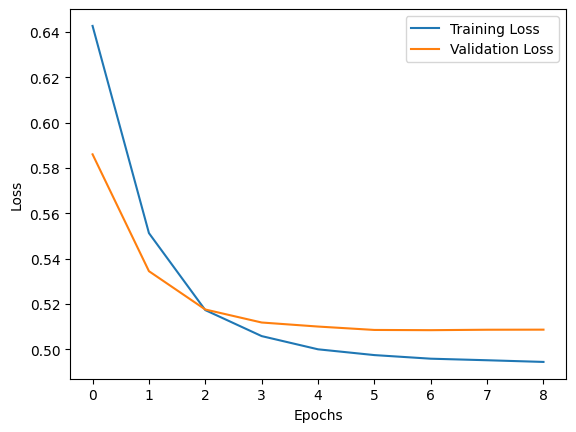

In [23]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
cols

(Index(['hour', 'target', 'text', 'tokenizer with lowercase',
        'tokenizer with lowercase, handle stripping, and length reduction',
        'tokenizer with lowercase and alpha',
        'tokenizer with lowercase, alpha and emoji',
        'tokenizer with lowercase, alpha, and no stop words',
        'tokenizer with lowercase, alpha and emoji, and no stop words'],
       dtype='object'),
 array([2, 0, 1, 3, 4, 5, 6, 7, 8]))

In [36]:
col_name = "tokenizer with lowercase"
train_ds, val_ds, test_ds = tf_ds_split(
    X_train,
    X_test,
    y_train,
    y_test,
    col_name,
)

In [37]:
for row in train_ds.take(1):
    print(row)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"i love asparagus . i just thouht i 'd express my vegetable love seeing as dad 's watching about it on the one show",
       b'arrrrhhh , i did it again i past 100 and now 200 i was gunna say it was my 200th update but i did nt get to again',
       b"losing one 's phone in the house while it 's set to & quot;silent&quot ; is not the best .",
       b'how do you deal with a long distance relationship help ? ? ?',
       b'bored of packing',
       b"@duckierenee i 've just read that , you 're evil and when are you coming to cook for me ?",
       b"@iphone_dev not having a mac means i ca n't use pwnage so   ca n't get the egg",
       b'@wickedgirl24 glad you like it',
       b'i am feeling like donald trump today .   this morning needs to get in line .  ',
       b"@pleasebiteme it 's totally fair",
       b"anti - gay protesters dwntwn make mooncheez sad   we support 1st amendmnt rights , but do n't agree with the msg . everyone 

In [38]:
# Define the parameters
max_features = 1000
sequence_length = 100
embedding_dim = 64

# Create a text datagenerator for the training set
vectorize_layer = TextVectorization(
    max_tokens=1000,
    output_sequence_length=100,
    output_mode="int",
)
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Map the vectorize function to the train, val and test datasets
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


2024-10-30 13:00:56.001762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [39]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_features, embedding_dim),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64,065
Trainable params: 64,065
Non-trainable params: 0
__________________________________________________

In [40]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)],
)

In [41]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"../weights/{col_name}_model.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [42]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10


   1/1597 [..............................] - ETA: 29:50 - loss: 0.6947 - binary_accuracy: 0.4688

2024-10-30 13:01:01.226081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-30 13:01:01.359324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:01:01.359381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-10-30 13:01:01.361995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:01:01.362048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1595/1597 [============================>.] - ETA: 0s - loss: 0.6419 - binary_accuracy: 0.6554

2024-10-30 13:01:26.380065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-30 13:01:26.404999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:01:26.405059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


1597/1597 [==============================] - 27s 16ms/step - loss: 0.6418 - binary_accuracy: 0.6555 - val_loss: 0.5842 - val_binary_accuracy: 0.7162
Epoch 2/10
1597/1597 [==============================] - 17s 11ms/step - loss: 0.5496 - binary_accuracy: 0.7378 - val_loss: 0.5336 - val_binary_accuracy: 0.7412
Epoch 3/10
1597/1597 [==============================] - 20s 13ms/step - loss: 0.5168 - binary_accuracy: 0.7563 - val_loss: 0.5189 - val_binary_accuracy: 0.7471
Epoch 4/10
1597/1597 [==============================] - 31s 19ms/step - loss: 0.5054 - binary_accuracy: 0.7635 - val_loss: 0.5121 - val_binary_accuracy: 0.7530
Epoch 5/10
1597/1597 [==============================] - 43s 27ms/step - loss: 0.5001 - binary_accuracy: 0.7662 - val_loss: 0.5094 - val_binary_accuracy: 0.7553
Epoch 6/10
 982/1597 [=================>............] - ETA: 17s - loss: 0.5008 - binary_accuracy: 0.7648

: 

KeyError: 'val_loss'

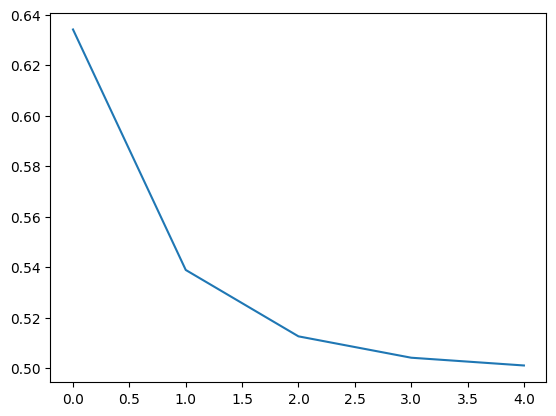

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
cols

NameError: name 'cols' is not defined

In [ ]:
col_name = "tokenizer with lowercase, handle stripping, and length reduction"
train_ds, val_ds, test_ds = tf_ds_split(
    X_train,
    X_test,
    y_train,
    y_test,
    col_name,
)

In [ ]:
for row in train_ds.take(1):
    print(row)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"i love asparagus . i just thouht i 'd express my vegetable love seeing as dad 's watching about it on the one show",
       b'arrrrhhh , i did it again i past 100 and now 200 i was gunna say it was my 200th update but i did nt get to again',
       b"losing one 's phone in the house while it 's set to & quot;silent&quot ; is not the best .",
       b'how do you deal with a long distance relationship help ? ? ?',
       b'bored of packing',
       b"@duckierenee i 've just read that , you 're evil and when are you coming to cook for me ?",
       b"@iphone_dev not having a mac means i ca n't use pwnage so   ca n't get the egg",
       b'@wickedgirl24 glad you like it',
       b'i am feeling like donald trump today .   this morning needs to get in line .  ',
       b"@pleasebiteme it 's totally fair",
       b"anti - gay protesters dwntwn make mooncheez sad   we support 1st amendmnt rights , but do n't agree with the msg . everyone 

In [ ]:
# Define the parameters
max_features = 1000
sequence_length = 100
embedding_dim = 64

# Create a text datagenerator for the training set
vectorize_layer = TextVectorization(
    max_tokens=1000,
    output_sequence_length=100,
    output_mode="int",
)
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Map the vectorize function to the train, val and test datasets
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


2024-10-30 10:30:13.345967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_features, embedding_dim),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64,065
Trainable params: 64,065
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)],
)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"../weights/{col}_model.h5", monitor="val_loss", save_best_only=True
    ),
]

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
   5/1597 [..............................] - ETA: 43s - loss: 0.6922 - binary_accuracy: 0.5063

2024-10-30 10:30:28.132195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-30 10:30:28.185732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 10:30:28.185787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 25405 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-10-30 10:30:28.187552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 10:30:28.187600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

 675/1597 [===========>..................] - ETA: 21s - loss: 0.6809 - binary_accuracy: 0.5994

KeyError: 'val_loss'

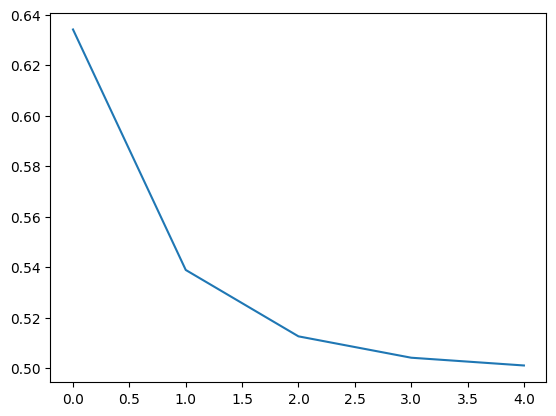

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()